In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

acc_hidden64 = []
acc_hidden128 = []


C:\Users\tjdwo\Anaconda3\envs\tf1.8\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])


C:\Users\tjdwo\Anaconda3\envs\tf1.8\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000])


<Figure size 640x480 with 1 Axes>

C:\Users\tjdwo\Anaconda3\envs\tf1.8\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\tjdwo\Anaconda3\envs\tf1.8\lib\site-packages\ipykernel\__main__.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\tjdwo\Anaconda3\envs\tf1.8\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# 3-2 change hidden nodes

In [2]:
hidden = 64
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=hidden,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc_hidden64.append(accuracy)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2883 | test accuracy: 0.10
Epoch:  0 | train loss: 0.8128 | test accuracy: 0.60
Epoch:  0 | train loss: 0.9328 | test accuracy: 0.74
Epoch:  0 | train loss: 0.8865 | test accuracy: 0.78
Epoch:  0 | train loss: 0.2789 | test accuracy: 0.87
Epoch:  0 | train loss: 0.2639 | test accuracy: 0.87
Epoch:  0 | train loss: 0.3271 | test accuracy: 0.91
Epoch:  0 | train loss: 0.4145 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1252 | test accuracy: 0.93
Epoch:  0 | train loss: 0.3034 | test accuracy: 0.91
Epoch:  0 | train loss: 0.0502 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2650 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0322 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1711 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2042 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1331 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0755 | test accurac

0.9535


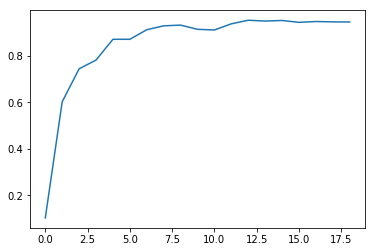

In [3]:
plt.plot(acc_hidden64)
print(max(acc_hidden64))

In [4]:
hidden = 128
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=hidden,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc_hidden128.append(accuracy)

RNN(
  (rnn): LSTM(28, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2902 | test accuracy: 0.09
Epoch:  0 | train loss: 1.0761 | test accuracy: 0.50
Epoch:  0 | train loss: 1.0191 | test accuracy: 0.68
Epoch:  0 | train loss: 0.5322 | test accuracy: 0.81
Epoch:  0 | train loss: 0.5192 | test accuracy: 0.81
Epoch:  0 | train loss: 0.1809 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2989 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1435 | test accuracy: 0.91
Epoch:  0 | train loss: 0.3821 | test accuracy: 0.93
Epoch:  0 | train loss: 0.3452 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1566 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2755 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1932 | test accuracy: 0.93
Epoch:  0 | train loss: 0.3079 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2014 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1138 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0079 | test accur

0.958


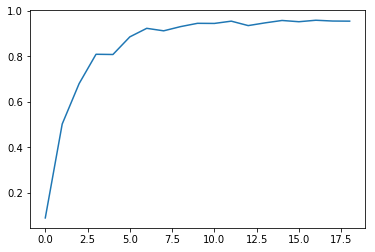

In [5]:
plt.plot(acc_hidden128)
print(max(acc_hidden128))

In [6]:
hidden = 16
acc_hidden16 = []
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=hidden,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc_hidden16.append(accuracy)

RNN(
  (rnn): LSTM(28, 16, batch_first=True)
  (out): Linear(in_features=16, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2993 | test accuracy: 0.10
Epoch:  0 | train loss: 1.3742 | test accuracy: 0.50
Epoch:  0 | train loss: 1.1313 | test accuracy: 0.58
Epoch:  0 | train loss: 0.9791 | test accuracy: 0.67
Epoch:  0 | train loss: 0.6734 | test accuracy: 0.71
Epoch:  0 | train loss: 0.5828 | test accuracy: 0.74
Epoch:  0 | train loss: 0.6358 | test accuracy: 0.79
Epoch:  0 | train loss: 0.5609 | test accuracy: 0.81
Epoch:  0 | train loss: 0.5708 | test accuracy: 0.81
Epoch:  0 | train loss: 0.4544 | test accuracy: 0.84
Epoch:  0 | train loss: 0.4538 | test accuracy: 0.85
Epoch:  0 | train loss: 0.3371 | test accuracy: 0.86
Epoch:  0 | train loss: 0.3372 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3971 | test accuracy: 0.88
Epoch:  0 | train loss: 0.3994 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2472 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1289 | test accurac

0.899


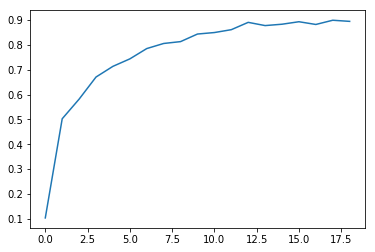

In [7]:
plt.plot(acc_hidden16)
print(max(acc_hidden16))

# 3-3 change the current optimization method

In [8]:
hidden = 64
optimization_method = torch.optim.Adam(rnn.parameters(), lr=LR)
acc_adam = []
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=hidden,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)# optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc_adam.append(accuracy)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3046 | test accuracy: 0.09
Epoch:  0 | train loss: 0.7992 | test accuracy: 0.59
Epoch:  0 | train loss: 0.6867 | test accuracy: 0.77
Epoch:  0 | train loss: 0.6376 | test accuracy: 0.79
Epoch:  0 | train loss: 0.2969 | test accuracy: 0.87
Epoch:  0 | train loss: 0.6239 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3826 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2087 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1124 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1052 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2720 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3006 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1704 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1327 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0689 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2029 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1956 | test accurac

0.9575


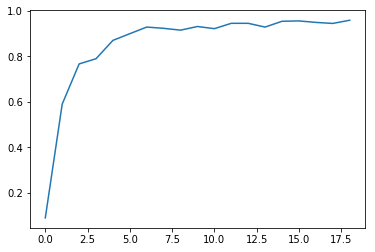

In [15]:
plt.plot(acc_adam)
print(max(acc_adam))

In [9]:
hidden = 64
optimization_method = torch.optim.Adagrad(rnn.parameters(), lr=LR)
acc_adaG = []
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=hidden,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adagrad(rnn.parameters(), lr=LR)# optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc_adaG.append(accuracy)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3030 | test accuracy: 0.11
Epoch:  0 | train loss: 1.1847 | test accuracy: 0.56
Epoch:  0 | train loss: 0.9608 | test accuracy: 0.66
Epoch:  0 | train loss: 0.9594 | test accuracy: 0.71
Epoch:  0 | train loss: 0.7809 | test accuracy: 0.73
Epoch:  0 | train loss: 0.7817 | test accuracy: 0.76
Epoch:  0 | train loss: 0.5571 | test accuracy: 0.79
Epoch:  0 | train loss: 0.6215 | test accuracy: 0.80
Epoch:  0 | train loss: 0.4006 | test accuracy: 0.83
Epoch:  0 | train loss: 0.3016 | test accuracy: 0.83
Epoch:  0 | train loss: 0.5081 | test accuracy: 0.83
Epoch:  0 | train loss: 0.3416 | test accuracy: 0.85
Epoch:  0 | train loss: 0.3437 | test accuracy: 0.85
Epoch:  0 | train loss: 0.4982 | test accuracy: 0.86
Epoch:  0 | train loss: 0.2628 | test accuracy: 0.87
Epoch:  0 | train loss: 0.3498 | test accuracy: 0.88
Epoch:  0 | train loss: 0.4969 | test accurac

0.8955


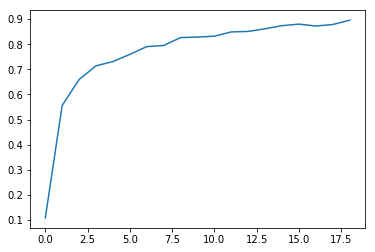

In [16]:
plt.plot(acc_adaG)
print(max(acc_adaG))

In [10]:
hidden = 64
optimization_method = torch.optim.RMSprop(rnn.parameters(), lr=LR)
acc_RMS = []
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=hidden,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.RMSprop(rnn.parameters(), lr=LR)# optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc_RMS.append(accuracy)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2927 | test accuracy: 0.12
Epoch:  0 | train loss: 1.3261 | test accuracy: 0.54
Epoch:  0 | train loss: 0.9087 | test accuracy: 0.65
Epoch:  0 | train loss: 0.7841 | test accuracy: 0.79
Epoch:  0 | train loss: 0.4474 | test accuracy: 0.85
Epoch:  0 | train loss: 0.2415 | test accuracy: 0.87
Epoch:  0 | train loss: 0.3010 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1883 | test accuracy: 0.88
Epoch:  0 | train loss: 0.4289 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1948 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2177 | test accuracy: 0.90
Epoch:  0 | train loss: 0.0462 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1955 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2906 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1508 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1994 | test accuracy: 0.93
Epoch:  0 | train loss: 0.4359 | test accurac

0.9545


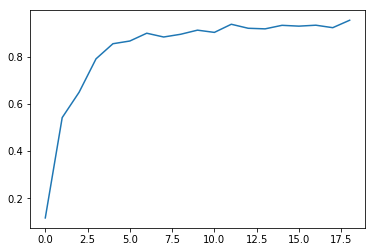

In [17]:
plt.plot(acc_RMS)
print(max(acc_RMS))

# 3-4 setting ‘weight_decay’ value

In [11]:
hidden = 64
weight_decay = 1e-5
optimization_method = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay=weight_decay)
acc_L2 = []

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=hidden,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay=weight_decay)# optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc_L2.append(accuracy)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3051 | test accuracy: 0.11
Epoch:  0 | train loss: 1.1226 | test accuracy: 0.60
Epoch:  0 | train loss: 0.6233 | test accuracy: 0.78
Epoch:  0 | train loss: 0.4666 | test accuracy: 0.83
Epoch:  0 | train loss: 0.1939 | test accuracy: 0.86
Epoch:  0 | train loss: 0.3738 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2362 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1533 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1875 | test accuracy: 0.91
Epoch:  0 | train loss: 0.3104 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2455 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2324 | test accuracy: 0.94
Epoch:  0 | train loss: 0.3324 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1493 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1488 | test accuracy: 0.94
Epoch:  0 | train loss: 0.5160 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1928 | test accurac

0.9505


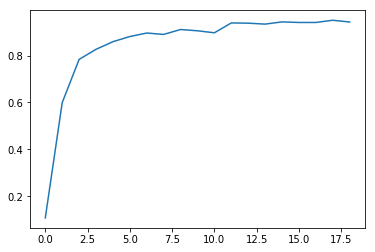

In [18]:
plt.plot(acc_L2)
print(max(acc_L2))

# 3-5 use dropout 

In [12]:
hidden = 64
weight_decay = 1e-5
optimization_method = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay=weight_decay)
dropout = 0.7
acc_dropout = []

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=hidden,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            dropout=dropout
        )

        self.out = nn.Linear(hidden, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay=weight_decay)# optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc_dropout.append(accuracy)

C:\Users\tjdwo\Anaconda3\envs\tf1.8\lib\site-packages\torch\nn\modules\rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RNN(
  (rnn): LSTM(28, 64, batch_first=True, dropout=0.7)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2967 | test accuracy: 0.12
Epoch:  0 | train loss: 1.2801 | test accuracy: 0.56
Epoch:  0 | train loss: 0.7489 | test accuracy: 0.73
Epoch:  0 | train loss: 0.4621 | test accuracy: 0.79
Epoch:  0 | train loss: 0.3593 | test accuracy: 0.88
Epoch:  0 | train loss: 0.3820 | test accuracy: 0.88
Epoch:  0 | train loss: 0.3836 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1908 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2320 | test accuracy: 0.91
Epoch:  0 | train loss: 0.3856 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1152 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2868 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1062 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2281 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1250 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0682 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1019 |

0.956


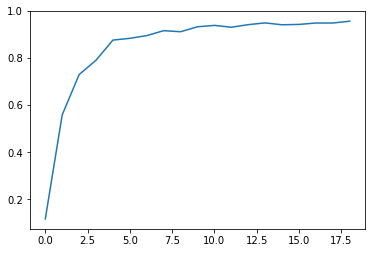

In [19]:
plt.plot(acc_dropout)
print(max(acc_dropout))

# 3-6 LSTM to GRU

In [13]:
hidden = 64
weight_decay = 1e-5
optimization_method = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay=weight_decay)
dropout = 0.7
acc_GRU = []

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.GRU(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=hidden,         # rnn hidden unit
            num_layers=2,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            dropout=dropout
        )

        self.out = nn.Linear(hidden, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay=weight_decay)# optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc_GRU.append(accuracy)

RNN(
  (rnn): GRU(28, 64, num_layers=2, batch_first=True, dropout=0.7)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3081 | test accuracy: 0.11
Epoch:  0 | train loss: 1.2296 | test accuracy: 0.60
Epoch:  0 | train loss: 0.6060 | test accuracy: 0.81
Epoch:  0 | train loss: 0.3839 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3824 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1171 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2925 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2272 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2347 | test accuracy: 0.90
Epoch:  0 | train loss: 0.0834 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1091 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1323 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2977 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1237 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2581 | test accuracy: 0.94
Epoch:  0 | train loss: 0.4143 | test accuracy: 0.95
Epoch:  0 | train l

0.95


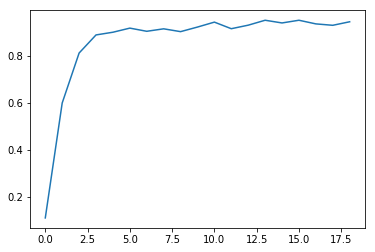

In [20]:
plt.plot(acc_GRU)
print(max(acc_GRU))

# 3-7 choose ONE other parameters of RNN program (batch_size 64 -> 128)

In [14]:
hidden = 64
weight_decay = 1e-5
optimization_method = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay=weight_decay)
dropout = 0.7
acc_batch128 = []

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.GRU(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=hidden,         # rnn hidden unit
            num_layers=2,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            dropout=dropout
        )

        self.out = nn.Linear(hidden, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay=weight_decay)# optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc_batch128.append(accuracy)

C:\Users\tjdwo\Anaconda3\envs\tf1.8\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\tjdwo\Anaconda3\envs\tf1.8\lib\site-packages\ipykernel\__main__.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\tjdwo\Anaconda3\envs\tf1.8\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


RNN(
  (rnn): GRU(28, 64, num_layers=2, batch_first=True, dropout=0.7)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3195 | test accuracy: 0.10
Epoch:  0 | train loss: 0.7821 | test accuracy: 0.70
Epoch:  0 | train loss: 0.4742 | test accuracy: 0.88
Epoch:  0 | train loss: 0.3315 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2207 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2170 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2173 | test accuracy: 0.94
Epoch:  0 | train loss: 0.3153 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1294 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1184 | test accuracy: 0.95


0.9545


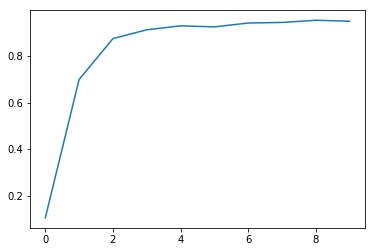

In [21]:
plt.plot(acc_batch128)
print(max(acc_batch128))

In [61]:
acc_list = [acc_hidden64, acc_hidden128, acc_hidden16, acc_adam, acc_adaG, acc_RMS, acc_L2, acc_dropout, acc_GRU, acc_batch128]

['acc_hidden64']
max accuracy :  0.9535
mean accuracy :  0.850
max - mean :  0.104

['acc_hidden128']
max accuracy :  0.958
mean accuracy :  0.844
max - mean :  0.114

['acc_hidden16']
max accuracy :  0.899
mean accuracy :  0.763
max - mean :  0.136

['acc_adam']
max accuracy :  0.9575
mean accuracy :  0.852
max - mean :  0.106

['acc_adaG']
max accuracy :  0.8955
mean accuracy :  0.767
max - mean :  0.128

['acc_RMS']
max accuracy :  0.9545
mean accuracy :  0.830
max - mean :  0.125

['acc_L2']
max accuracy :  0.9505
mean accuracy :  0.847
max - mean :  0.104

['acc_dropout']
max accuracy :  0.956
mean accuracy :  0.848
max - mean :  0.108

['acc_GRU']
max accuracy :  0.95
mean accuracy :  0.857
max - mean :  0.093

['acc_batch128']
max accuracy :  0.9545
mean accuracy :  0.824


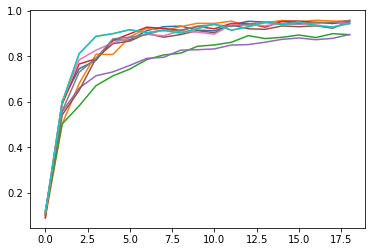

In [91]:
import inspect


def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


for i in range(len(acc_list)-1):
    
    print(retrieve_name(acc_list[i]))
    _max = max(acc_list[i])
    print("max accuracy : ",_max)
    
    _mean = "%0.3f"%(sum(acc_list[i])/len(acc_list[i]))
    print("mean accuracy : ", _mean)
    
    sub = "%0.3f"%(float(_max) - float(_mean))
    print("max - mean : ", sub)
    
    plt.plot(acc_list[i])
    print()
    
print([retrieve_name(acc_list[len(acc_list)-1])[0]])
print("max accuracy : ",max(acc_list[len(acc_list)-1]))
print("mean accuracy : ", "%0.3f"%(sum(acc_list[len(acc_list)-1])/len(acc_list[len(acc_list)-1])))
plt.plot(acc_list[i])



# 3-8 compare the accuracy of RNN for Mnist with that of CNN.

## cnn 결과는 hw 4-1에서 가져왔습니다.

### 이미지를 별첨하여 비교하겠습니다.

# CNN-RNN 정확도 비교.png 파일입니다.